# CS 135 day11: Neural Networks and XOR

# Objectives

* Gain intuition for how multi-layer perceptrons (MLPs) can solve the XOR problem
* Get practice using sklearn's MLPClassifier

# Outline

* [Part 1: XOR using sklearn's MLP with 2 hidden units](#part1)
* [Part 2: Understanding how MLPs make predictions](#part2)
* [Part 3: Trying larger models](#part3)
* [Part 3: Intuition for the "universal approximation" abilities of neural nets](#part3)

We expect you'll get through the first 2 parts for sure during the in-class session.

# Takeaways

* MLPs with hidden units can have non-linear decision boundaries
* More hidden units lead to more flexible boundaries
* sklearn has code to fit MLPs efficiently (using gradient methods, we'll learn more next class)
* The learning objective for MLPs is NOT convex, so local optima may cause challenges
* -- Always take the best of multiple runs if you want the best performance
* With enough hidden units, an MLP can learn to approximate *any* function (assuming the function isn't crazy)


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sklearn.neural_network

In [ ]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Setup

### Make training set for XOR toy example

We want a "real" dataset where each instance has F=2 features, and there is an XOR like decision boundary needed

In [ ]:
def make_xor_dataset(n_per_blob=50, stddev=0.4, random_state=0):
    random_state = np.random.RandomState(random_state)
    cov_22 = np.square(stddev) * np.eye(2)
    x_00 = random_state.multivariate_normal([-1, -1], cov_22, size=n_per_blob)
    x_01 = random_state.multivariate_normal([-1, +1], cov_22, size=n_per_blob)
    x_10 = random_state.multivariate_normal([+1, -1], cov_22, size=n_per_blob)
    x_11 = random_state.multivariate_normal([+1, +1], cov_22, size=n_per_blob)

    N = n_per_blob * 4
    x_N2 = np.vstack([x_00, x_11, x_01, x_10])
    assert x_N2.shape == (N, 2)

    y_N = np.hstack([np.ones(N//2), np.zeros(N//2)]).astype(np.int32)
    assert y_N.shape == (N,)

    # Shuffle the order
    perm_ids = random_state.permutation(N)
    x_N2 = x_N2[perm_ids].copy()
    y_N = y_N[perm_ids].copy()

    return x_N2, y_N

In [ ]:
x_tr_N2, y_tr_N = make_xor_dataset(n_per_blob=50)

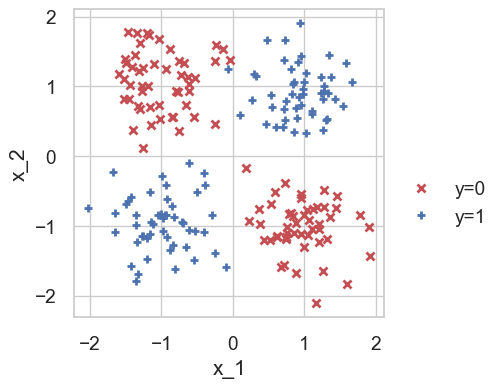

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(x_tr_N2[y_tr_N==0,0], x_tr_N2[y_tr_N==0,1], 'rx', label='y=0', mew=2);
plt.plot(x_tr_N2[y_tr_N==1,0], x_tr_N2[y_tr_N==1,1], 'b+', label='y=1', mew=2);

plt.xlabel('x_1');
plt.ylabel('x_2');
plt.legend(bbox_to_anchor=(1.0, 0.5));

# Setup: Create Utility function for visualizing classifier predictions

You do NOT need to understand the details of this function. We'll just use it as is.

In [ ]:
def plot_pretty_probabilities_for_clf(
        clf,
        ax=None,
        x1_grid=(-2.1, 2.1, 50), x2_grid=(-2.1, 2.1, 50),
        x1_ticks=[-1, 0, 1], x2_ticks=[-1, 0, 1],
        do_show_colorbar=False,
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        c_num_levels=100,
        ):
    ''' Display predicted probabilities from classifier as color contour plot

    Args
    ----
    clf : sklearn object that implements classifier API
    ax : matplotlib axis handle, or None
        If provided, will use axis handle as primary axis to plot on.
        If None, will use the current handle, or make new one as necessary.
    x1_grid : tuple-like or array-like
        If tuple of length 3, interpreted as args to np.linspace
        Otherwise, cast to array and assumed to be a 1d grid of x1 values
    x2_grid : tuple-like or array-like
        If tuple of length 3, interpreted as args to np.linspace
        Otherwise, cast to array and assumed to be a 1d grid of x2 values

    '''
    # Activate the current axis, if necessary
    if ax is None:
        cur_ax = plt.gca()
    else:
        cur_ax = ax
        plt.sca(cur_ax)

    # Create dense grid of x1 and x2 values
    # useful for visualizing probabilities
    if isinstance(x1_grid, tuple) and len(x1_grid) == 3:
        x1_grid = np.linspace(x1_grid[0], x1_grid[1], x1_grid[2])
    if isinstance(x2_grid, tuple) and len(x2_grid) == 3:
        x2_grid = np.linspace(x2_grid[0], x2_grid[1], x2_grid[2])
    x1_grid = np.asarray(x1_grid).flatten()
    x2_grid = np.asarray(x2_grid).flatten()

    c_levels = np.linspace(0.0, 1.0, c_num_levels)

    # Get regular grid of G x H points, where each point is an (x1, x2) location
    G = x1_grid.size
    H = x2_grid.size    
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    # Contour plot
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(
            x1_GH, x2_GH, yproba1_GH,
            levels=c_levels, vmin=0, vmax=1.0,
            cmap=cmap, alpha=0.5)

    # Edit the ticks observed
    if x1_ticks is not None:
        plt.xticks(x1_ticks, x1_ticks);
    if x2_ticks is not None:
        plt.yticks(x2_ticks, x2_ticks);
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left + 1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

# Part 1: Visualizing MLPClassifier on XOR

Here, we'll use sklearn's MLPClassifier, with 2 input features, 2 hidden units (with ReLU activation), and 1 output.

You can read more about this here:

<https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html>

## Try an MLP with 2 hidden units and random seed of 5 

Random seed determines initial weight parameter values

In [ ]:
mlp_2hidden_run5 = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=[2],
    activation='relu',
    solver='lbfgs',
    random_state=5,
    )

In [ ]:
# Fit the model to training data

mlp_2hidden_run5.fit(x_tr_N2, y_tr_N)

MLPClassifier(hidden_layer_sizes=[2], random_state=5, solver='lbfgs')

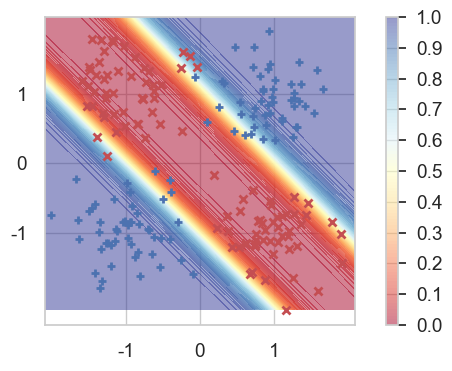

In [ ]:
# Visualize the results using our utility function

plt.figure(figsize=(4,4))
plot_pretty_probabilities_for_clf(mlp_2hidden_run5, do_show_colorbar=True, ax=plt.gca());

plt.plot(x_tr_N2[y_tr_N==0,0], x_tr_N2[y_tr_N==0,1], 'rx', label='y=0', mew=2);
plt.plot(x_tr_N2[y_tr_N==1,0], x_tr_N2[y_tr_N==1,1], 'b+', label='y=1', mew=2);

### Discussion 1a: Roughly, by inspecting the plot what accuracy does this model get? Near 50%? Near 100%?

Warning: if your lab group contains many people with different computing platforms, you may not get the same results.

In [ ]:
# TODO discuss

### Exercise 1b : Write code to compute the accuracy on the training set

Use the `predict` method to produce hard binary decisions for each input examples.

Use `x_tr_N2` as the input array, and compare your predictions to the known "true" labels `y_tr_N`

In [ ]:
# TODO call mlp.predict(...)

## Try another MLP with 2 hidden units and random seed 0

Lets try again with a different random seed (controls the initial parameters)

In [ ]:
mlp_2hidden_run0 = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=[2],
    activation='relu',
    solver='lbfgs',
    random_state=0,
    )

In [ ]:
mlp_2hidden_run0.fit(x_tr_N2, y_tr_N)

MLPClassifier(hidden_layer_sizes=[2], random_state=0, solver='lbfgs')

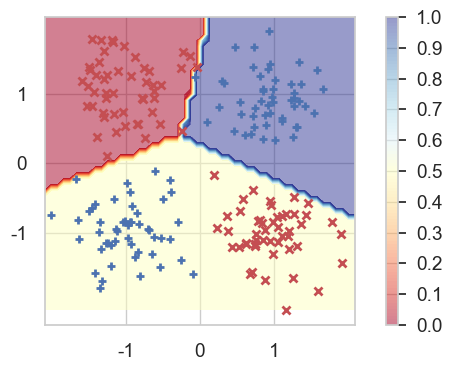

In [ ]:
# Visualize the results using our utility function

plt.figure(figsize=(4,4))
plot_pretty_probabilities_for_clf(mlp_2hidden_run0, do_show_colorbar=True, ax=plt.gca());

plt.plot(x_tr_N2[y_tr_N==0,0], x_tr_N2[y_tr_N==0,1], 'rx', label='y=0', mew=2);
plt.plot(x_tr_N2[y_tr_N==1,0], x_tr_N2[y_tr_N==1,1], 'b+', label='y=1', mew=2);

## Try again, another MLP with 2 hidden units and random seed 1

Third time's a charm?

In [ ]:
mlp_2hidden_run1 = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=[2],
    activation='relu',
    solver='lbfgs',
    random_state=1,
    )

In [ ]:
mlp_2hidden_run1.fit(x_tr_N2, y_tr_N)

MLPClassifier(hidden_layer_sizes=[2], random_state=1, solver='lbfgs')

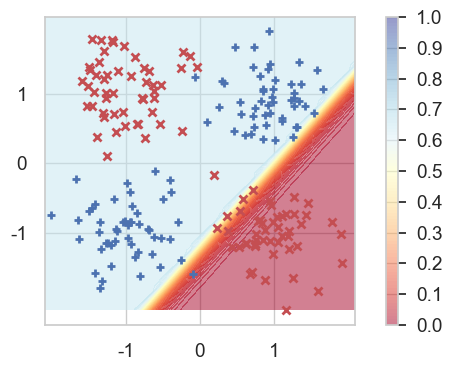

In [ ]:
# Visualize the results using our utility function

plt.figure(figsize=(4,4))
plot_pretty_probabilities_for_clf(mlp_2hidden_run1, do_show_colorbar=True, ax=plt.gca());

plt.plot(x_tr_N2[y_tr_N==0,0], x_tr_N2[y_tr_N==0,1], 'rx', label='y=0', mew=2);
plt.plot(x_tr_N2[y_tr_N==1,0], x_tr_N2[y_tr_N==1,1], 'b+', label='y=1', mew=2);

### Discussion 1b: Do your 3 different MLPs give 3 different accuracies? What's going on here?

Seems like 3 different initializations led to 3 different answers, even when we had the *same* training objective.

When this is true, likely the objective is *not* convex. This means we have to worry about *local optima*.

# Part 2: Understanding how MLPs make predictions

### What parameters were learned?

We can print out the *weight values* used at each of the 2 layers (hidden layer then output layer)

`coefs_` is a LIST

* First entry are the weights for hidden layer
* Second entry are weights for the output layer

In [ ]:
mlp_2hidden_run5.coefs_

[array([[-2.27680431,  1.75190676],
        [-2.1830434 ,  1.61917491]]),
 array([[3.12368911],
        [3.73738249]])]

We can also print out the *intercepts* at each of the 2 layers (hidden layer then output layer)

`intercepts_` is a LIST

* First entry are the intercepts for the hidden layer
* Second entry is intercept for the output layer

In [ ]:
mlp_2hidden_run5.intercepts_

[array([-0.04133857,  0.01889374]), array([-6.79060349])]

### Exercise 2a: Can you finish the implementation of predict_proba?

In [ ]:
from scipy.special import expit as sigmoid

In [ ]:
def relu(x):
    return np.maximum(x, 0.0)

In [ ]:
def predict_proba(x_NF, coef_list, intercept_list, hidden_activation=relu, output_activation=sigmoid):
    ''' Should give same output as sklearn MLPClassifier's predict_proba
    
    Returns
    -------
    yproba1_N : 1D array, shape (N,)
        Probability that each input example has label y=1
        Should match exactly the result of mlp.predict_proba(...)[:,1]
    '''
    n_layers = len(coef_list)
    
    out_arr = x_NF
    
    for layer_id in range(n_layers):
        # Get w and b arrays for current layer
        w_arr = coef_list[layer_id]
        b_arr = intercept_list[layer_id]
        
        # Perform the linear operation: X * w + b
        out_arr = np.dot(out_arr, w_arr) + b_arr
        
        if layer_id < (n_layers - 1):
            # Hidden layer
            
            # Use the hidden layer activation here
            out_arr = hidden_activation(out_arr)
        else:
            # Output layer (the last possible layer)
            
            # TODO output activation goes here
            out_arr = 1.0 * out_arr # FIXME

    yproba1_N = np.squeeze(out_arr) # squeeze into a 1D array
    return yproba1_N

Results from our implementation on the first 5 examples of our training set:

In [ ]:
predict_proba(x_tr_N2[:5], mlp_2hidden_run5.coefs_, mlp_2hidden_run5.intercepts_)

array([ 4.52143568, -6.27261756,  5.99717607,  6.22750067,  3.76204765])

Check the above against sklearn's implementation (they should match exactly!)

In [ ]:
mlp_2hidden_run5.predict_proba(x_tr_N2[:5])[:,1]

array([0.98924356, 0.00188373, 0.9975204 , 0.99802951, 0.97729154])

# Part 3: Trying larger models

Above, we just used 1 hidden layer with 2 units.

We'll try something bigger...

## Try with 32 hidden units


In [ ]:
mlp_32hidden = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=[32],
    activation='relu',
    solver='lbfgs',
    random_state=1,
    )

In [ ]:
mlp_32hidden.fit(x_tr_N2, y_tr_N)

MLPClassifier(hidden_layer_sizes=[32], random_state=1, solver='lbfgs')

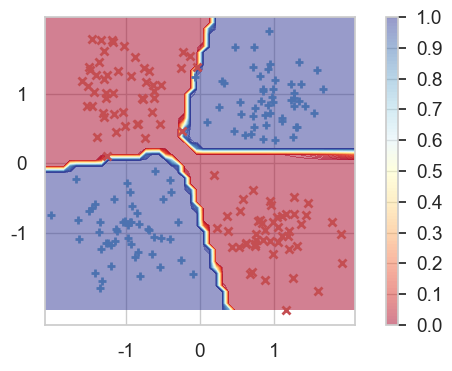

In [ ]:
# Visualize the results using our utility function

plt.figure(figsize=(4,4))
plot_pretty_probabilities_for_clf(mlp_32hidden, do_show_colorbar=True, ax=plt.gca());

plt.plot(x_tr_N2[y_tr_N==0,0], x_tr_N2[y_tr_N==0,1], 'rx', label='y=0', mew=2);
plt.plot(x_tr_N2[y_tr_N==1,0], x_tr_N2[y_tr_N==1,1], 'b+', label='y=1', mew=2);

### Discussion 3a: What is qualitatively different about the boundaries here?

In [ ]:
# TODO answer here

### Exercise 3b: Fit your own MLP with 256 hidden units

In [ ]:
mlp_256hidden = None # TODO your code here


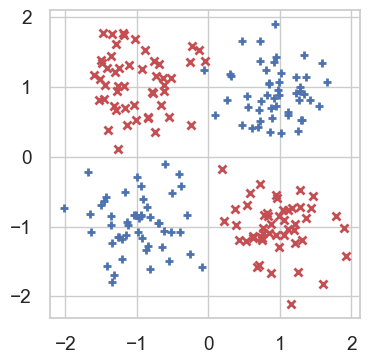

In [ ]:
# Visualize the results

plt.figure(figsize=(4,4))
# TODO call plot_pretty_probabilities_for_clf(..., do_show_colorbar=True, ax=plt.gca());

plt.plot(x_tr_N2[y_tr_N==0,0], x_tr_N2[y_tr_N==0,1], 'rx', label='y=0', mew=2);
plt.plot(x_tr_N2[y_tr_N==1,0], x_tr_N2[y_tr_N==1,1], 'b+', label='y=1', mew=2);

# Part 4 (Bonus): Intuition for the "universal approximation" of MLPs

The ability of MLPs to approximate any function is quite amazing.

To get intuition, please feel free to try out the following demo:
    
<http://neuralnetworksanddeeplearning.com/chap4.html#universality_with_one_input_and_one_output>

If you work through that interactive tutorial step by step, you'll get some very nice intuition.

This is bonus content, but will really help you gain understanding about these models.